
    HEC-RAS 2D ADVANCED POST-PROCESSING SUITE

[INFO] Loading data from: C:\2d_hec_ras\unsteady_2d.p01.hdf
[INFO] Processing area: flow_area
[WARN] Velocity data not found - some analyses will be limited
[INFO] Loaded: 73 timesteps, 670 cells (565 valid)

[MODULE 1] Critical Locations Analysis
   ✓ Max Depth: 6.425 m at (407404.4, 4360330.3)
   ✓ Max Rate of Rise: 5.5560 m/step
   ✓ Valid flooded cells: 224

[MODULE 2] Spatial Clustering (Hotspot Detection)
   ✓ Identified 1 flood hotspots
     - Cluster 0: 220 cells, max depth 6.42 m

[MODULE 3] Temporal Dynamics Analysis
   ✓ Peak at timestep 25: 359415 m³
   ✓ Max inundated area: 14.27 ha
   ✓ Rising rate: 14376.6 m³/step

[MODULE 4] Hazard Classification
   Hazard Distribution:
     - None: 480 cells (71.6%)
     - Low: 34 cells (5.1%)
     - Moderate: 54 cells (8.1%)
     - Significant: 49 cells (7.3%)
     - Extreme: 53 cells (7.9%)

                    COMPREHENSIVE FLOOD ANALYSIS REPORT

CRITICAL LOCATIONS
--------------------

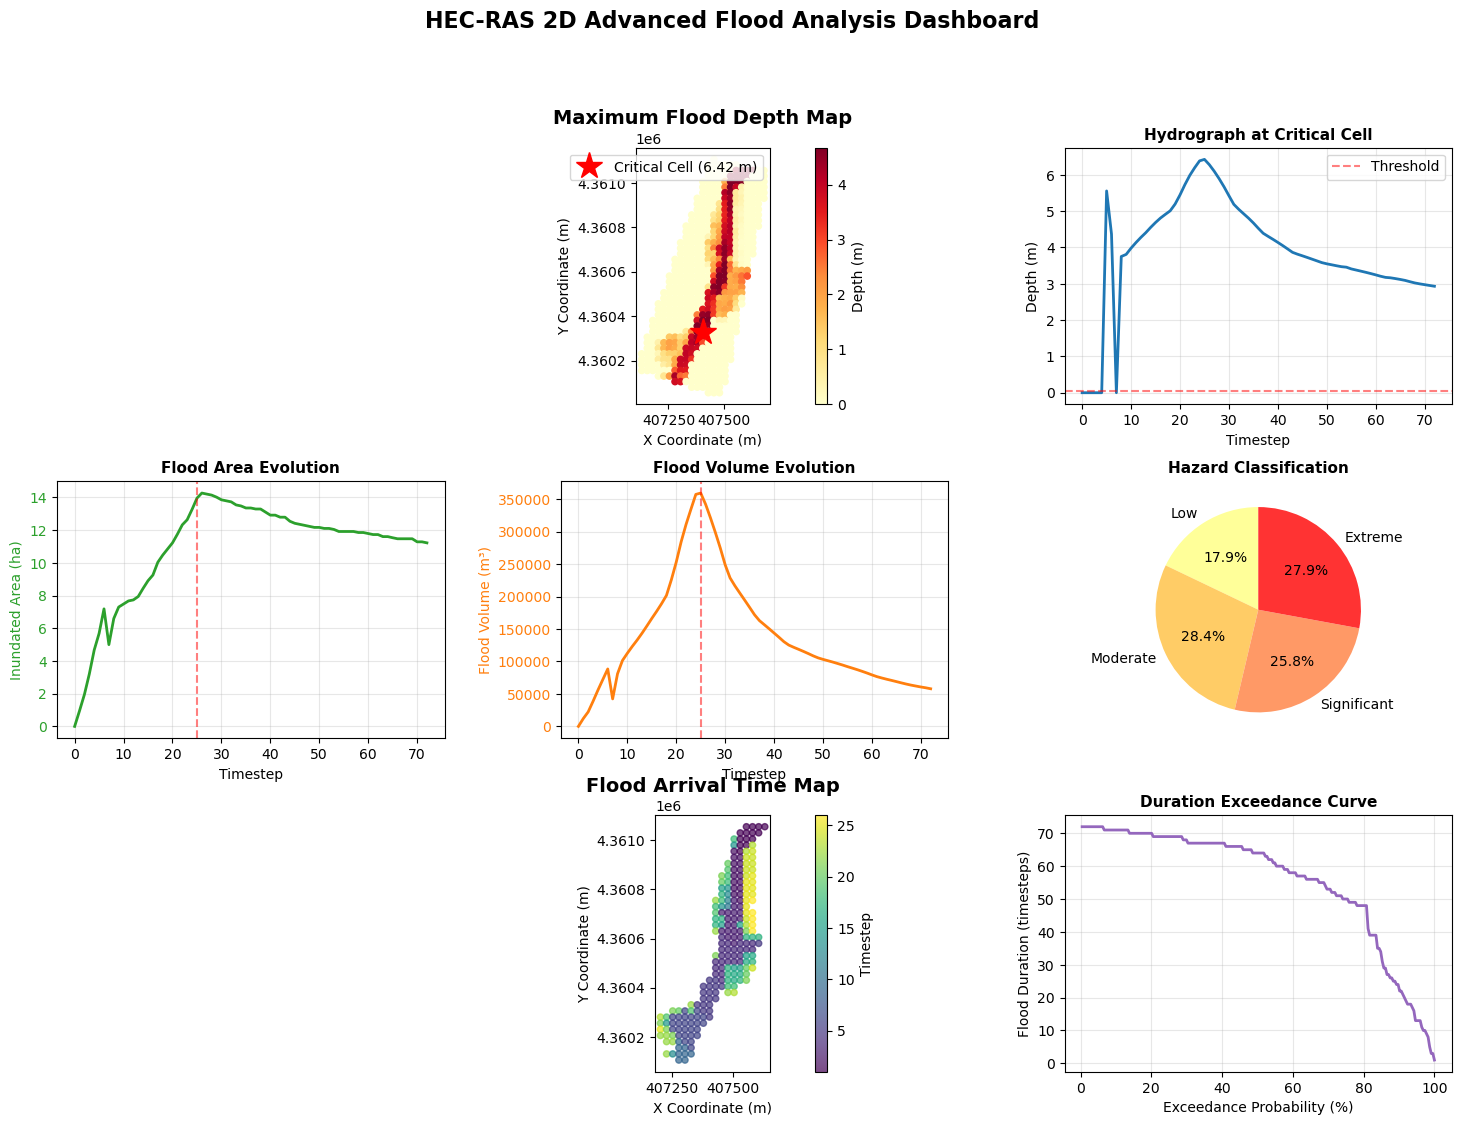


[EXPORT] Saving results to CSV...
   ✓ Cell statistics saved to 'cell_statistics.csv'
   ✓ Global time series saved to 'timeseries_global.csv'
   ✓ Critical cell data saved to 'critical_cell_hydrograph.csv'

ANALYSIS COMPLETE


In [10]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
from scipy import ndimage, stats
from scipy.spatial import cKDTree
from sklearn.cluster import DBSCAN
import seaborn as sns
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LinearSegmentedColormap
import warnings
warnings.filterwarnings('ignore')

# --- CONFIGURATION ---
HDF_FILE_PATH = r"C:\2d_hec_ras\unsteady_2d.p01.hdf"
FLOOD_THRESHOLD = 0.05  # meters
HAZARD_VELOCITY = 2.0   # m/s - threshold for high hazard
HAZARD_DEPTH = 1.0      # m - threshold for high hazard
OUTPUT_DIR = r"C:\2d_hec_ras\analysis_output"

class HECRASAnalyzer:
    """Advanced HEC-RAS 2D results analyzer with spatial-temporal analytics"""
    
    def __init__(self, hdf_path):
        self.hdf_path = hdf_path
        self.data = {}
        self.results = {}
        
    def load_data(self):
        """Load and preprocess all relevant datasets"""
        print(f"[INFO] Loading data from: {self.hdf_path}")
        
        with h5py.File(self.hdf_path, 'r') as f:
            results_base = '/Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/2D Flow Areas'
            geometry_base = '/Geometry/2D Flow Areas'
            
            area_name = list(f[results_base].keys())[0]
            print(f"[INFO] Processing area: {area_name}")
            
            # Load geometry
            terrain_raw = f[f'{geometry_base}/{area_name}/Cells Minimum Elevation'][:]
            self.data['cell_areas'] = f[f'{geometry_base}/{area_name}/Cells Surface Area'][:]
            self.data['coords'] = f[f'{geometry_base}/{area_name}/Cells Center Coordinate'][:]
            
            # Load hydraulic variables
            wse_raw = f[f'{results_base}/{area_name}/Water Surface'][:]
            
            # CRITICAL: Clean NaN and invalid values
            # Replace NaN in terrain with a very high value (dry cells)
            self.data['terrain'] = np.where(np.isnan(terrain_raw), 9999, terrain_raw)
            
            # Replace NaN in WSE with terrain elevation (dry cells)
            self.data['wse'] = np.where(np.isnan(wse_raw), self.data['terrain'], wse_raw)
            
            # Try to load velocity if available
            try:
                vel_raw = f[f'{results_base}/{area_name}/Velocity'][:]
                self.data['velocity'] = np.where(np.isnan(vel_raw), 0, vel_raw)
                print("[INFO] Velocity data loaded")
            except KeyError:
                print("[WARN] Velocity data not found - some analyses will be limited")
                self.data['velocity'] = None
            
            # Calculate depth with cleaned data
            self.data['depth'] = self.data['wse'] - self.data['terrain']
            self.data['depth'] = np.maximum(self.data['depth'], 0)  # Remove negatives
            
            # Additional cleaning: replace any remaining NaN with 0
            self.data['depth'] = np.nan_to_num(self.data['depth'], nan=0.0)
            self.data['cell_areas'] = np.nan_to_num(self.data['cell_areas'], nan=0.0)
            
            # Time information
            self.data['n_timesteps'] = self.data['depth'].shape[0]
            self.data['n_cells'] = self.data['depth'].shape[1]
            
            # Quality check
            valid_cells = np.sum(self.data['cell_areas'] > 0)
            print(f"[INFO] Loaded: {self.data['n_timesteps']} timesteps, {self.data['n_cells']} cells ({valid_cells} valid)")
    
    def critical_locations_analysis(self):
        """Enhanced critical locations with multiple criteria"""
        print("\n[MODULE 1] Critical Locations Analysis")
        
        depth = self.data['depth']
        coords = self.data['coords']
        cell_areas = self.data['cell_areas']
        
        # Filter valid cells (with area > 0)
        valid_mask = cell_areas > 0
        
        # Maximum depth analysis (only valid cells)
        max_depth = np.max(depth, axis=0)
        max_depth_valid = np.where(valid_mask, max_depth, -9999)
        critical_depth_idx = np.argmax(max_depth_valid)
        
        # Time of arrival (first exceedance)
        toa = np.full(self.data['n_cells'], -1)
        for cell in range(self.data['n_cells']):
            if valid_mask[cell]:
                exceeds = np.where(depth[:, cell] > FLOOD_THRESHOLD)[0]
                if len(exceeds) > 0:
                    toa[cell] = exceeds[0]
        
        # Duration above threshold
        duration = np.sum(depth > FLOOD_THRESHOLD, axis=0)
        
        # Rate of rise (max gradient) - only for valid cells
        depth_gradient = np.diff(depth, axis=0)
        rate_of_rise = np.max(depth_gradient, axis=0)
        rate_of_rise_valid = np.where(valid_mask, rate_of_rise, -9999)
        critical_ror_idx = np.argmax(rate_of_rise_valid)
        
        # Velocity-based hazard (if available)
        if self.data['velocity'] is not None:
            max_velocity = np.max(self.data['velocity'], axis=0)
            max_velocity = np.nan_to_num(max_velocity, nan=0.0)
            # Hazard = depth × velocity (simplified)
            hazard_score = max_depth * max_velocity
            hazard_score_valid = np.where(valid_mask, hazard_score, -9999)
            critical_hazard_idx = np.argmax(hazard_score_valid)
        else:
            max_velocity = None
            hazard_score = max_depth  # Fallback to depth only
            critical_hazard_idx = critical_depth_idx
        
        self.results['critical'] = {
            'max_depth_idx': critical_depth_idx,
            'max_depth_value': max_depth[critical_depth_idx],
            'max_depth_coords': coords[critical_depth_idx],
            'ror_idx': critical_ror_idx,
            'ror_value': rate_of_rise[critical_ror_idx],
            'hazard_idx': critical_hazard_idx,
            'toa': toa,
            'duration': duration,
            'max_depth': max_depth,
            'max_velocity': max_velocity,
            'hazard_score': hazard_score
        }
        
        print(f"   ✓ Max Depth: {max_depth[critical_depth_idx]:.3f} m at ({coords[critical_depth_idx][0]:.1f}, {coords[critical_depth_idx][1]:.1f})")
        print(f"   ✓ Max Rate of Rise: {rate_of_rise[critical_ror_idx]:.4f} m/step")
        print(f"   ✓ Valid flooded cells: {np.sum(max_depth > FLOOD_THRESHOLD)}")
        
    def spatial_clustering_analysis(self):
        """Identify hotspots using spatial clustering"""
        print("\n[MODULE 2] Spatial Clustering (Hotspot Detection)")
        
        max_depth = self.results['critical']['max_depth']
        coords = self.data['coords']
        cell_areas = self.data['cell_areas']
        
        # Filter cells with significant flooding AND valid area
        valid_mask = cell_areas > 0
        significant = (max_depth > FLOOD_THRESHOLD * 2) & valid_mask
        
        if np.sum(significant) < 5:
            print(f"   [WARN] Insufficient flooded cells for clustering (found {np.sum(significant)})")
            self.results['clusters'] = None
            return
        
        coords_flooded = coords[significant]
        depths_flooded = max_depth[significant]
        
        # DBSCAN clustering
        clustering = DBSCAN(eps=50, min_samples=5).fit(coords_flooded)
        labels = clustering.labels_
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        
        # Analyze each cluster
        cluster_stats = []
        for cluster_id in range(n_clusters):
            mask = labels == cluster_id
            if np.sum(mask) > 0:
                cluster_stats.append({
                    'id': cluster_id,
                    'n_cells': np.sum(mask),
                    'mean_depth': np.mean(depths_flooded[mask]),
                    'max_depth': np.max(depths_flooded[mask]),
                    'centroid': np.mean(coords_flooded[mask], axis=0)
                })
        
        self.results['clusters'] = {
            'labels': labels,
            'coords': coords_flooded,
            'depths': depths_flooded,
            'stats': cluster_stats,
            'n_clusters': n_clusters
        }
        
        print(f"   ✓ Identified {n_clusters} flood hotspots")
        for stat in cluster_stats[:3]:  # Top 3
            print(f"     - Cluster {stat['id']}: {stat['n_cells']} cells, max depth {stat['max_depth']:.2f} m")
    
    def temporal_dynamics_analysis(self):
        """Analyze temporal flood dynamics"""
        print("\n[MODULE 3] Temporal Dynamics Analysis")
        
        depth = self.data['depth']
        cell_areas = self.data['cell_areas']
        
        # Filter valid cells
        valid_mask = cell_areas > 0
        
        # Global metrics over time
        wet_mask = depth > FLOOD_THRESHOLD
        
        # Calculate area and volume only for valid cells
        total_area = np.zeros(self.data['n_timesteps'])
        total_volume = np.zeros(self.data['n_timesteps'])
        
        for t in range(self.data['n_timesteps']):
            valid_wet = wet_mask[t] & valid_mask
            total_area[t] = np.sum(cell_areas[valid_wet]) / 10000  # hectares
            total_volume[t] = np.sum(cell_areas[valid_wet] * depth[t][valid_wet])
        
        # Peak timing
        peak_time = np.argmax(total_volume)
        
        # Rising and recession limbs
        if peak_time > 0 and total_volume[peak_time] > 0:
            rising_rate = (total_volume[peak_time] - total_volume[0]) / peak_time
        else:
            rising_rate = 0
            
        if peak_time < len(total_volume) - 1 and total_volume[peak_time] > 0:
            recession_rate = (total_volume[-1] - total_volume[peak_time]) / (len(total_volume) - peak_time)
        else:
            recession_rate = 0
        
        # Duration metrics
        max_vol = np.max(total_volume)
        if max_vol > 0:
            threshold_90pct = 0.9 * max_vol
            above_90pct = total_volume > threshold_90pct
            duration_90pct = np.sum(above_90pct)
        else:
            duration_90pct = 0
        
        self.results['temporal'] = {
            'total_area': total_area,
            'total_volume': total_volume,
            'peak_time': peak_time,
            'peak_volume': total_volume[peak_time],
            'rising_rate': rising_rate,
            'recession_rate': recession_rate,
            'duration_90pct': duration_90pct
        }
        
        print(f"   ✓ Peak at timestep {peak_time}: {total_volume[peak_time]:.0f} m³")
        print(f"   ✓ Max inundated area: {np.max(total_area):.2f} ha")
        print(f"   ✓ Rising rate: {rising_rate:.1f} m³/step")
    
    def hazard_classification(self):
        """Classify cells by flood hazard level"""
        print("\n[MODULE 4] Hazard Classification")
        
        max_depth = self.results['critical']['max_depth']
        max_velocity = self.results['critical']['max_velocity']
        
        # Hazard classes (Australian/UK standard)
        # H = d × (v + 0.5) where d=depth, v=velocity
        if max_velocity is not None:
            hazard_index = max_depth * (max_velocity + 0.5)
        else:
            hazard_index = max_depth * 0.5  # Simplified without velocity
        
        # Classification
        hazard_class = np.zeros_like(hazard_index, dtype=int)
        hazard_class[hazard_index > 0.3] = 1   # Low
        hazard_class[hazard_index > 0.75] = 2  # Moderate
        hazard_class[hazard_index > 1.25] = 3  # Significant
        hazard_class[hazard_index > 2.0] = 4   # Extreme
        
        # Count cells per class
        class_names = ['None', 'Low', 'Moderate', 'Significant', 'Extreme']
        class_counts = [np.sum(hazard_class == i) for i in range(5)]
        
        self.results['hazard'] = {
            'index': hazard_index,
            'class': hazard_class,
            'class_names': class_names,
            'class_counts': class_counts
        }
        
        print("   Hazard Distribution:")
        for i, (name, count) in enumerate(zip(class_names, class_counts)):
            pct = 100 * count / len(hazard_class)
            if pct > 0.1:
                print(f"     - {name}: {count} cells ({pct:.1f}%)")
    
    def generate_comprehensive_report(self):
        """Generate detailed text report"""
        print("\n" + "="*70)
        print("                    COMPREHENSIVE FLOOD ANALYSIS REPORT")
        print("="*70)
        
        print("\nCRITICAL LOCATIONS")
        print("-" * 70)
        crit = self.results['critical']
        print(f"  Maximum Depth Location:")
        print(f"    • Coordinates: ({crit['max_depth_coords'][0]:.2f}, {crit['max_depth_coords'][1]:.2f})")
        print(f"    • Peak Depth: {crit['max_depth_value']:.3f} m")
        print(f"    • Cell ID: {crit['max_depth_idx']}")
        
        print(f"\n  Fastest Rising Location:")
        print(f"    • Rate of Rise: {crit['ror_value']:.4f} m/timestep")
        print(f"    • Cell ID: {crit['ror_idx']}")
        
        if self.results['clusters']:
            print(f"\nSPATIAL PATTERNS")
            print("-" * 70)
            print(f"  Identified {self.results['clusters']['n_clusters']} distinct flood zones")
            for stat in self.results['clusters']['stats'][:3]:
                print(f"  Zone {stat['id'] + 1}:")
                print(f"    • Size: {stat['n_cells']} cells")
                print(f"    • Average Depth: {stat['mean_depth']:.2f} m")
                print(f"    • Maximum Depth: {stat['max_depth']:.2f} m")
        
        print(f"\nTEMPORAL EVOLUTION")
        print("-" * 70)
        temp = self.results['temporal']
        print(f"  Peak flood occurs at timestep {temp['peak_time']}")
        print(f"  Maximum inundated area: {np.max(temp['total_area']):.2f} hectares")
        print(f"  Peak flood volume: {temp['peak_volume']:.0f} m³")
        print(f"  Flood rising rate: {temp['rising_rate']:.1f} m³/timestep")
        print(f"  Duration above 90% peak: {temp['duration_90pct']} timesteps")
        
        print(f"\nHAZARD ASSESSMENT")
        print("-" * 70)
        haz = self.results['hazard']
        print("  Flood Hazard Classification:")
        for name, count in zip(haz['class_names'][1:], haz['class_counts'][1:]):
            if count > 0:
                area_ha = count * np.mean(self.data['cell_areas']) / 10000
                print(f"    • {name:12s}: {count:6d} cells ({area_ha:.2f} ha)")
        
        print("\n" + "="*70)
    
    def create_visualizations(self):
        """Generate comprehensive visualization suite"""
        print("\n[VISUALIZATION] Generating plots...")
        
        fig = plt.figure(figsize=(18, 12))
        gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
        
        # 1. Spatial flood map with maximum depth
        ax1 = fig.add_subplot(gs[0, :2])
        coords = self.data['coords']
        max_depth = self.results['critical']['max_depth']
        valid_mask = self.data['cell_areas'] > 0
        
        # Plot only valid cells
        coords_valid = coords[valid_mask]
        max_depth_valid = max_depth[valid_mask]
        
        vmax = np.percentile(max_depth_valid[max_depth_valid > 0], 95) if np.any(max_depth_valid > 0) else 1.0
        
        scatter = ax1.scatter(coords_valid[:, 0], coords_valid[:, 1], c=max_depth_valid, 
                            s=20, cmap='YlOrRd', vmin=0, vmax=vmax)
        ax1.set_title('Maximum Flood Depth Map', fontsize=14, fontweight='bold')
        ax1.set_xlabel('X Coordinate (m)')
        ax1.set_ylabel('Y Coordinate (m)')
        plt.colorbar(scatter, ax=ax1, label='Depth (m)')
        ax1.set_aspect('equal')
        
        # Mark critical location
        crit_coords = self.results['critical']['max_depth_coords']
        crit_val = self.results['critical']['max_depth_value']
        ax1.plot(crit_coords[0], crit_coords[1], 'r*', markersize=20, 
                label=f"Critical Cell ({crit_val:.2f} m)")
        ax1.legend()
        
        # 2. Time series at critical cell
        ax2 = fig.add_subplot(gs[0, 2])
        critical_idx = self.results['critical']['max_depth_idx']
        depth_series = self.data['depth'][:, critical_idx]
        ax2.plot(depth_series, color='#1f77b4', linewidth=2)
        ax2.axhline(FLOOD_THRESHOLD, color='red', linestyle='--', alpha=0.5, label='Threshold')
        ax2.set_title(f'Hydrograph at Critical Cell', fontsize=11, fontweight='bold')
        ax2.set_xlabel('Timestep')
        ax2.set_ylabel('Depth (m)')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        
        # 3. Flood evolution (area and volume)
        ax3 = fig.add_subplot(gs[1, 0])
        temp = self.results['temporal']
        color = '#2ca02c'
        ax3.plot(temp['total_area'], color=color, linewidth=2)
        ax3.axvline(temp['peak_time'], color='red', linestyle='--', alpha=0.5, label='Peak')
        ax3.set_xlabel('Timestep')
        ax3.set_ylabel('Inundated Area (ha)', color=color)
        ax3.tick_params(axis='y', labelcolor=color)
        ax3.set_title('Flood Area Evolution', fontsize=11, fontweight='bold')
        ax3.grid(True, alpha=0.3)
        
        # 4. Volume evolution
        ax4 = fig.add_subplot(gs[1, 1])
        color = '#ff7f0e'
        if np.max(temp['total_volume']) > 0:  # Only plot if there's actual volume
            ax4.plot(temp['total_volume'], color=color, linewidth=2)
            ax4.axvline(temp['peak_time'], color='red', linestyle='--', alpha=0.5)
        ax4.set_xlabel('Timestep')
        ax4.set_ylabel('Flood Volume (m³)', color=color)
        ax4.tick_params(axis='y', labelcolor=color)
        ax4.set_title('Flood Volume Evolution', fontsize=11, fontweight='bold')
        ax4.grid(True, alpha=0.3)
        
        # 5. Hazard classification pie chart
        ax5 = fig.add_subplot(gs[1, 2])
        haz = self.results['hazard']
        # Filter out 'None' class for better visualization
        labels = [haz['class_names'][i] for i in range(1, 5) if haz['class_counts'][i] > 0]
        sizes = [haz['class_counts'][i] for i in range(1, 5) if haz['class_counts'][i] > 0]
        colors_pie = ['#ffff99', '#ffcc66', '#ff9966', '#ff3333'][:len(labels)]
        
        if len(sizes) > 0:
            ax5.pie(sizes, labels=labels, colors=colors_pie, autopct='%1.1f%%', startangle=90)
            ax5.set_title('Hazard Classification', fontsize=11, fontweight='bold')
        
        # 6. Time of Arrival map
        ax6 = fig.add_subplot(gs[2, :2])
        toa = self.results['critical']['toa']
        
        # Plot only cells that flooded (toa >= 0) and are valid
        flooded_mask = (toa >= 0) & valid_mask
        if np.sum(flooded_mask) > 0:
            coords_flooded = coords[flooded_mask]
            toa_flooded = toa[flooded_mask]
            scatter2 = ax6.scatter(coords_flooded[:, 0], coords_flooded[:, 1], 
                                 c=toa_flooded, s=20, cmap='viridis', alpha=0.7)
            plt.colorbar(scatter2, ax=ax6, label='Timestep')
        
        ax6.set_title('Flood Arrival Time Map', fontsize=14, fontweight='bold')
        ax6.set_xlabel('X Coordinate (m)')
        ax6.set_ylabel('Y Coordinate (m)')
        ax6.set_aspect('equal')
        
        # 7. Depth duration curve
        ax7 = fig.add_subplot(gs[2, 2])
        duration = self.results['critical']['duration']
        duration_sorted = np.sort(duration[duration > 0])[::-1]
        exceedance = 100 * np.arange(1, len(duration_sorted) + 1) / len(duration_sorted)
        ax7.plot(exceedance, duration_sorted, color='#9467bd', linewidth=2)
        ax7.set_xlabel('Exceedance Probability (%)')
        ax7.set_ylabel('Flood Duration (timesteps)')
        ax7.set_title('Duration Exceedance Curve', fontsize=11, fontweight='bold')
        ax7.grid(True, alpha=0.3)
        
        plt.suptitle('HEC-RAS 2D Advanced Flood Analysis Dashboard', 
                    fontsize=16, fontweight='bold', y=0.995)
        
        plt.savefig('flood_analysis_dashboard.png', dpi=300, bbox_inches='tight')
        print("   ✓ Dashboard saved as 'flood_analysis_dashboard.png'")
        plt.show()
    
    def export_results(self):
        """Export results to CSV files"""
        print("\n[EXPORT] Saving results to CSV...")
        
        # Export 1: Cell-based statistics
        df_cells = pd.DataFrame({
            'X': self.data['coords'][:, 0],
            'Y': self.data['coords'][:, 1],
            'Max_Depth_m': self.results['critical']['max_depth'],
            'Time_of_Arrival': self.results['critical']['toa'],
            'Duration_timesteps': self.results['critical']['duration'],
            'Hazard_Class': self.results['hazard']['class'],
            'Hazard_Index': self.results['hazard']['index']
        })
        df_cells.to_csv('cell_statistics.csv', index=False)
        print("   ✓ Cell statistics saved to 'cell_statistics.csv'")
        
        # Export 2: Time series
        df_timeseries = pd.DataFrame({
            'Timestep': range(self.data['n_timesteps']),
            'Total_Area_ha': self.results['temporal']['total_area'],
            'Total_Volume_m3': self.results['temporal']['total_volume']
        })
        df_timeseries.to_csv('timeseries_global.csv', index=False)
        print("   ✓ Global time series saved to 'timeseries_global.csv'")
        
        # Export 3: Critical cell hydrograph
        critical_idx = self.results['critical']['max_depth_idx']
        df_critical = pd.DataFrame({
            'Timestep': range(self.data['n_timesteps']),
            'Depth_m': self.data['depth'][:, critical_idx],
            'WSE_m': self.data['wse'][:, critical_idx]
        })
        df_critical.to_csv('critical_cell_hydrograph.csv', index=False)
        print("   ✓ Critical cell data saved to 'critical_cell_hydrograph.csv'")
    
    def run_full_analysis(self):
        """Execute complete analysis pipeline"""
        print("\n" + "="*70)
        print("    HEC-RAS 2D ADVANCED POST-PROCESSING SUITE")
        print("="*70 + "\n")
        
        self.load_data()
        self.critical_locations_analysis()
        self.spatial_clustering_analysis()
        self.temporal_dynamics_analysis()
        self.hazard_classification()
        self.generate_comprehensive_report()
        self.create_visualizations()
        self.export_results()
        
        print("\n" + "="*70)
        print("ANALYSIS COMPLETE")
        print("="*70)


# ========== EXECUTION ==========
if __name__ == "__main__":
    analyzer = HECRASAnalyzer(HDF_FILE_PATH)
    analyzer.run_full_analysis()